# 实验2：传输层TCP协议实验

## 5.1 网络仿真环境运行和实验网络搭建
<img width=450 src="figures/mininet-topo.png">

In [1]:
from mininet.topo import Topo
from mininet.node import CPULimitedHost, OVSController
from mininet.link import TCLink
from mininet.net import Mininet
from mininet.log import lg, info
from mininet.util import dumpNodeConnections

class BBTopo(Topo):
    "Simple topology for bufferbloat experiment."

    def __init__(self, queue_size):
        super(BBTopo, self).__init__()
        
        # Create router s0 (这里不区分交换机和路由器，统一用addSwitch命令添加)
        s0 = self.addSwitch('s0')
        
        # Create two hosts with names 'h1' and 'h2'
        h1 = self.addHost('h1')
        h2 = self.addHost('h2')
        
        # Add links with appropriate bandwidth, delay, and queue size parameters. 
        # Set the router queue size using the queue_size argument
        # Set bandwidths/latencies using the bandwidths and minimum RTT given in the network diagram above
        self.addLink(h1, s0, bw=1000, delay='10ms', max_queue_size=queue_size)
        self.addLink(h2, s0, bw=1.5, delay='10ms', max_queue_size=queue_size)
        return

import os
# Set the cwnd control algorithm to "reno"
os.system("sysctl -w net.ipv4.tcp_congestion_control=reno")
# create the topology with queue_size=10
topo = BBTopo(queue_size=10)

# validate the built topology
print('构建网络中包含的节点：')
print(topo.nodes())
print('构建网络中包含的链路：')
for i, link in enumerate(topo.links()):
    print('第%d条链路：' % (i+1))
    print(link)
    print('第%d条链路信息：' % (i+1))
    print(topo.linkInfo(link[0], link[1]))


from subprocess import call
# Clean mininet files
call(["mn", "-c"])
# Create the network
net = Mininet(topo=topo, host=CPULimitedHost, link=TCLink, controller= OVSController)
net.start()
# Print the network topology 
dumpNodeConnections(net.hosts)
# Performs a basic all pairs ping test to ensure the network set up properly
print("\ntest all pair pings")
print("packet loss percentage: %f" % net.pingAll())
# Print the IP of hosts
for host in net.hosts:
    print(host.name, host.IP())

构建网络中包含的节点：
['h1', 'h2', 's0']
构建网络中包含的链路：
第1条链路：
('h2', 's0')
第1条链路信息：
{'delay': '10ms', 'bw': 1.5, 'max_queue_size': 10, 'node1': 'h2', 'node2': 's0', 'port2': 2, 'port1': 0}
第2条链路：
('h1', 's0')
第2条链路信息：
{'delay': '10ms', 'bw': 1000, 'max_queue_size': 10, 'node1': 'h1', 'node2': 's0', 'port2': 1, 'port1': 0}


h1 h1-eth0:s0-eth1
h2 h2-eth0:s0-eth2
*** Ping: testing ping reachability
h1 -> h2 
h2 -> h1 
*** Results: 0% dropped (2/2 received)



test all pair pings
packet loss percentage: 0.000000
('h1', '10.0.0.1')
('h2', '10.0.0.2')


## 5.2 TCP连接建立和数据包抓取

In [2]:
# Start capturing packets
from subprocess import Popen
experiment_name = 'test_10'    # set experiment name
tcpdumper = Popen("tcpdump -S -w ./{}_tcpdumper.pcap".format(experiment_name), shell=True)

import time
t_iperf = time.time()

import os
def start_tcpprobe(outfile="cwnd.txt"):
    Popen("sudo modprobe tcp_probe", shell=True)
    Popen("sudo cat /proc/net/tcpprobe > " + outfile, shell=True)

def stop_tcpprobe():
    Popen("killall -9 cat", shell=True).wait()
    
# Start monitoring TCP cwnd size
outfile = "{}_cwnd.txt".format(experiment_name)

start_tcpprobe(outfile)

def start_iperf(net, experiment_time):
    # Start a TCP server on host 'h2' using perf. 
    # The -s parameter specifies server mode
    # The -w 16m parameter ensures that the TCP flow is not receiver window limited (not necessary for client)
    print("Starting iperf server")
    h2 = net.get('h2')
    server = h2.popen("iperf -s -w 16m", shell=True)
    
    print("Starting iperf client")
    h1 = net.get('h1')
    # Start an TCP client on host 'h1' using iperf. Ensure that the client runs for experiment_time seconds
    client = h1.popen("iperf -c {0} -t {1}".format(h2.IP(), experiment_time), shell=True)
    
# Start the long lived TCP connections with start_iperf
experiment_time = 30
start_iperf(net, experiment_time)    

def start_ping(net, outfile="pings.txt"):
    # Start a ping train from h1 to h2 with 0.1 seconds between pings, redirecting stdout to outfile
    print("Starting ping...")
    h1 = net.get('h1')
    h2 = net.get('h2')
    h1.popen("ping -i 0.1 {0} > {1}".format(h2.IP(),outfile), shell=True)

# Start pings with the start_ping() function
outfile = "{}_pings.txt".format(experiment_name)
t_ping = time.time()
start_ping(net, outfile)

# Close the environment
from time import time
import os
from subprocess import call
from time import sleep

# Keep several seconds for probing
sleep(experiment_time*1.5)

# Stop probing 
stop_tcpprobe()
net.stop()

tcpdumper.kill()
# Ensure that all processes you create within Mininet are killed.
call(["mn", "-c"])
print('simulation finished')

Starting iperf server
Starting iperf client
Starting ping...
simulation finished


## 5.3 TCP连接管理
#### 根据实验指导书要求，利用Wireshark完成

## 5.4 TCP可靠传输
#### 根据实验指导书要求，利用Wireshark完成
#### 运行下放代码，观察基于ping的采样RTT和基于tcpprobe的估计RTT之间的差别

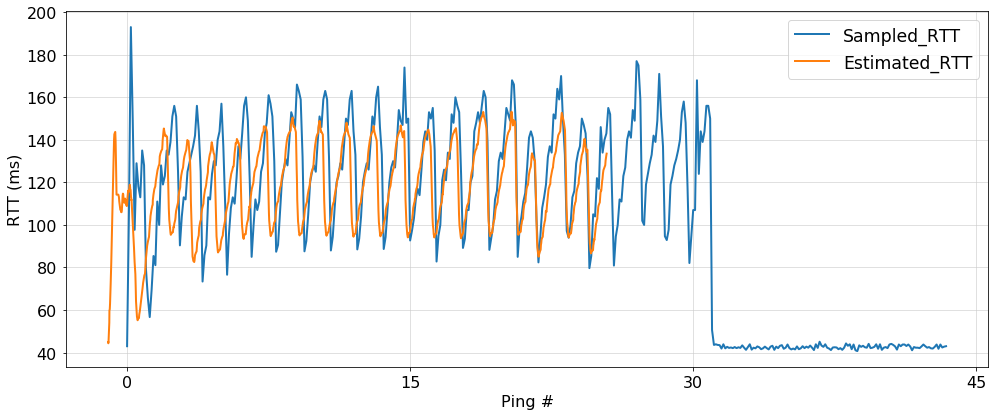

In [4]:
from plot_ertt import plot_srtt_ertt
plot_srtt_ertt('test_10')

## 5.5 TCP流量控制
#### 根据实验指导书要求，利用Wireshark完成，记录接收窗变化并分析

## 5.6 TCP拥塞控制

In [ ]:
%matplotlib inline
from plot_cwnd import plot_congestion_window
plot_congestion_window('test_10_cwnd.txt', histogram=False)